In [1]:
from scipy import ndimage
from scipy.ndimage.filters import convolve
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg

## Canny Edge Detector

In [2]:
class cannyEdgeDetector:
    
    def __init__(self,sigma=1,kernel_size=5,weak_pixel=50,strong_pixel=255,lowThreshold=4,highThreshold=45):
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.lowThreshold = lowThreshold
        self.highThreshold = highThreshold
    
    def rgb2gray(self,img):
        """Converts rgb image to gray"""
        return 0.3*img[:,:,0] + 0.59*img[:,:,1] + 0.11*img[:,:,2]
    
    def gaussian(self,x,y,sigma):
        """2D gaussian"""
        return np.exp(-((x**2 + y**2)/(2*(sigma**2))))
    
    def gaussian_kernel(self,size,sigma):
        """Forms 2D gaussian kernel with variance=sigma and shape=(size,size)"""
        size = int(size)//2
        x,y = np.mgrid[-size:size+1,-size:size+1]
        out = self.gaussian(x,y,sigma)
        out = out / np.sum(np.sum(out))
        return out
    
    def sobel_filtering(self,img):
        """Performs soble filtering and returns the magnitude and direction of edges"""
        ky = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
        kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        
        gx = convolve(img,kx)
        gy = convolve(img,ky)
        
        M = np.hypot(gx,gy)
        alpha = np.arctan2(gy,gx)      # Values are in range [-pi,pi]
        
        alpha = np.rad2deg(alpha)
        alpha[alpha<0] += 180          # Values are in range [0,180]
        
        return (M,alpha)

    def non_max_suppression(self,M,alpha):
        """Performs non-maximal suppression using the magnitude and direction of edges obtained using sobel filtering.
        If there is no neighbour in the edge direction with pixel intensity greater than the current pixel, then its value is kept otherwise it is set to 0."""
        out = np.zeros(M.shape,dtype=np.uint8)
        PI = 180 # In degrees
        # Cases for all angles for all pixels
        for i in range(1,M.shape[0]-1):
            for j in range(1,M.shape[1]-1):
                angle = alpha[i][j]
                a = b = 255
                if((0 <= angle < PI/8) or (7*PI/8 <= angle < 2*PI)):
                    a = M[i,j+1]
                    b = M[i,j-1]
                
                elif(PI/8 <= angle < 3*PI/8):
                    a = M[i+1,j-1]
                    b = M[i-1,j+1]
                
                elif(3*PI/8 <= angle < 5*PI/8):
                    a = M[i+1,j]
                    b = M[i-1,j]
                    
                elif(5*PI/8 <= angle < 7*PI/8):
                    a = M[i-1,j-1]
                    b = M[i+1,j+1]
                
                if((M[i,j]>=a) and (M[i,j]>=b)):
                    out[i,j] = M[i,j]
        return out
    
    def threshold(self,img):
        """ Performs hysteresis thresholding. Identifies strong and weak edges using thresholds"""
        out = np.zeros(img.shape,dtype=np.uint8)
        strong = self.strong_pixel
        weak = self.weak_pixel
        if not self.highThreshold:
            self.highThreshold = 0.8*img.max()
        if not self.lowThreshold:
            self.lowThreshold = 0.2*img.max()
        high = self.highThreshold
        low = self.lowThreshold
        row_h,col_h = np.where(img>=high)
        row_w,col_w = np.where((img<=high) & (img>=low))
        out[row_h,col_h] = strong
        out[row_w,col_w] = weak

        return out
    
    def edge_linking(self,img):
        """Weak pixel edges are linked if there is a strong edge in neighbourhood."""
        s = self.strong_pixel
        w = self.weak_pixel
        for i in range(1,img.shape[0]-1):
            for j in range(1,img.shape[1]-1):
                if(img[i,j]==w):
                    if((img[i+1,j+1]==s) or (img[i+1,j]==s) or (img[i+1,j-1]==s) 
                        or (img[i,j+1]==s) or (img[i,j-1]==s) 
                        or (img[i-1,j+1]==s) or (img[i-1,j]==s) or (img[i-1,j-1]==s)):
                        img[i,j] = 255
                    else:
                        img[i,j] = 0
        return img

    def detect(self,img):
        """Driver function for the algorithm"""
        img = self.rgb2gray(img)
        smoothed = convolve(img,self.gaussian_kernel(self.kernel_size,self.sigma))
        M,alpha = self.sobel_filtering(smoothed)
        nonMaxSuppression = self.non_max_suppression(M,alpha)
        threshold = self.threshold(nonMaxSuppression)
        out = self.edge_linking(threshold)
        return out

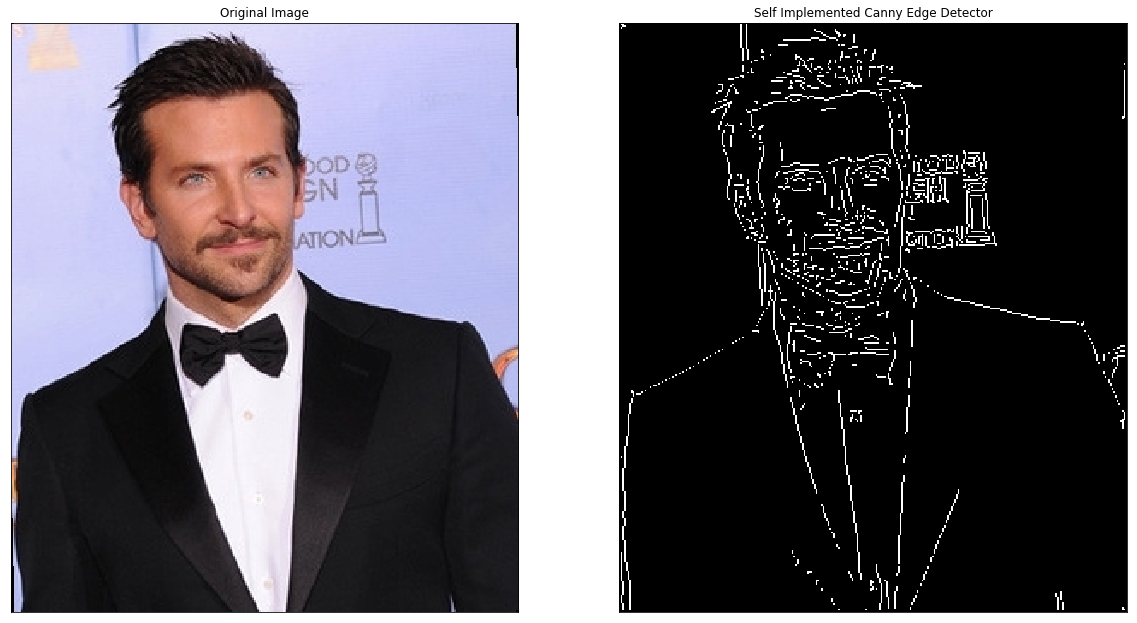

In [3]:
img = mpimg.imread('2.jpg')
detector = cannyEdgeDetector(lowThreshold=4, highThreshold=43)
out = detector.detect(img)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img,'gray')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.title('Self Implemented Canny Edge Detector')
plt.imshow(out,'gray')
plt.xticks([])
plt.yticks([])
plt.show()

## Open-CV Canny Edge Detector

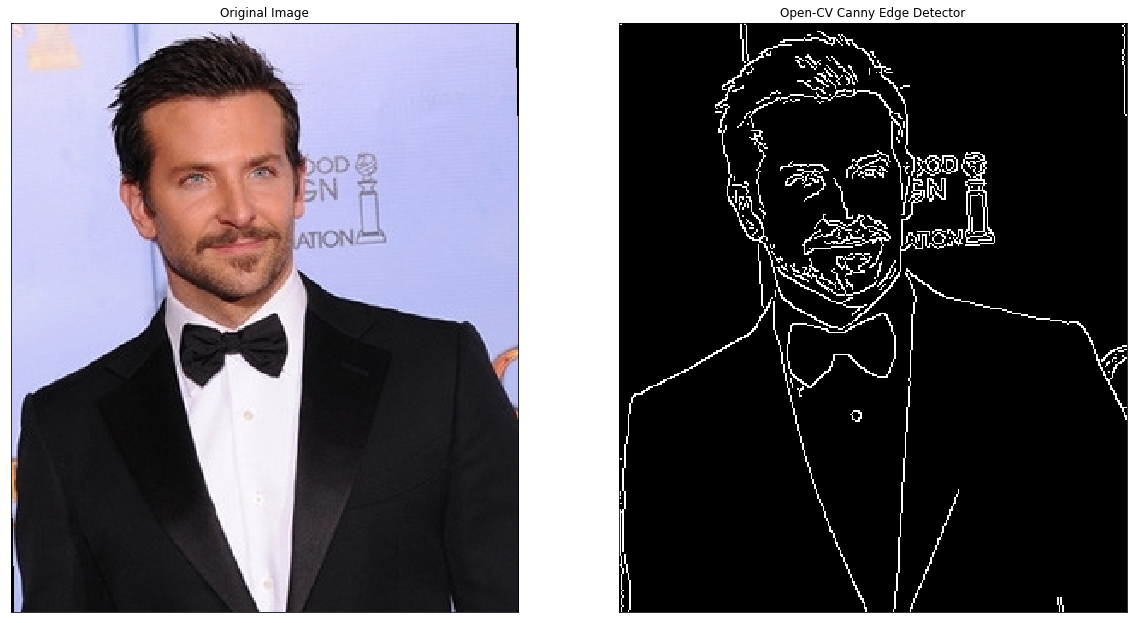

In [4]:
out_cv2 = cv2.Canny(img,100,200)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img,'gray')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.title('Open-CV Canny Edge Detector')
plt.imshow(out_cv2,'gray')
plt.xticks([])
plt.yticks([])
plt.show()

## Harris Corner Detector

In [5]:
class harrisCornerDetector:
    
    def __init__(self,kernel_size=5,sigma=1,threshold=10):
        self.kernel_size=kernel_size
        self.sigma = sigma
        self.threshold = threshold
        
    def rgb2gray(self,img):
        """Converts rgb image to gray image"""
        return 0.3*img[:,:,0] + 0.59*img[:,:,1] + 0.11*img[:,:,2]
    
    def gaussian(self,x,y,sigma):
        """2D Gaussian"""
        return np.exp(-((x**2 + y**2)/(2*(sigma**2))))
    
    def gaussian_kernel(self,size,sigma):
        """Forms 2D gaussian kernel with variance=sigma and shape=(size,size)"""
        size = int(size)//2
        x,y = np.mgrid[-size:size+1,-size:size+1]
        out = self.gaussian(x,y,sigma)
        out = out / np.sum(np.sum(out))
        return out
    
    def filtering(self,img):
        """Performs gaussian smoothing on the image followed by sobel filtering. Returns results of all."""
        G = self.gaussian_kernel(self.kernel_size,self.sigma)
        Sy = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
        Sx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        
        Ig = convolve(img,G)
        Ix = convolve(Ig,Sx)
        Iy = convolve(Ig,Sy)
        return (Ig,Ix,Iy)
    
    def squaring(self,Ig,Ix,Iy):
        """Performs squaring and multiplication operations on the sobel filtered images"""
        Ixx = Ix ** 2
        Iyy = Iy ** 2
        Ixy = np.multiply(Ix,Iy)
        assert Ixx.shape==Iyy.shape==Ixy.shape==Ig.shape
        return (Ixx,Iyy,Ixy)
    
    def smoothing(self,Ixx,Iyy,Ixy):
        """Perfroms gaussian smoothing on the outputs of above function"""
        Ixx_hat = convolve(Ixx,self.gaussian_kernel(self.kernel_size,self.sigma))
        Iyy_hat = convolve(Iyy,self.gaussian_kernel(self.kernel_size,self.sigma))
        Ixy_hat = convolve(Ixy,self.gaussian_kernel(self.kernel_size,self.sigma))
        return (Ixx_hat,Iyy_hat,Ixy_hat)

    def eigenvalue_calculation(self,Ixx_hat,Iyy_hat,Ixy_hat):
        """Calculates the eigenvalues of matrices at each pixel location and forms the matrix R with same shape as original image"""
        R = np.zeros(Ixx_hat.shape)
        k = 0.05
        for i in range(Ixx_hat.shape[0]):
            for j in range(Ixx_hat.shape[1]):
                w,v = np.linalg.eig(np.array([[Ixx_hat[i,j],Ixy_hat[i,j]],[Ixy_hat[i,j],Iyy_hat[i,j]]]))
                R[i,j] = w[0]*w[1] - k*((w[0]+w[1])**2)
        return R
    
    def detect(self,rgb_img):
        """Driver function for the algorithm"""
        rgb_img = rgb_img.copy()
        img = self.rgb2gray(rgb_img)
        Ig,Ix,Iy = self.filtering(img)
        Ixx,Iyy,Ixy = self.squaring(Ig,Ix,Iy)
        Ixx_hat,Iyy_hat,Ixy_hat = self.smoothing(Ixx,Iyy,Ixy)
        R = self.eigenvalue_calculation(Ixx_hat,Iyy_hat,Ixy_hat)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if(R[i,j]>self.threshold):
                    rgb_img[i,j,0] = 255
        return rgb_img

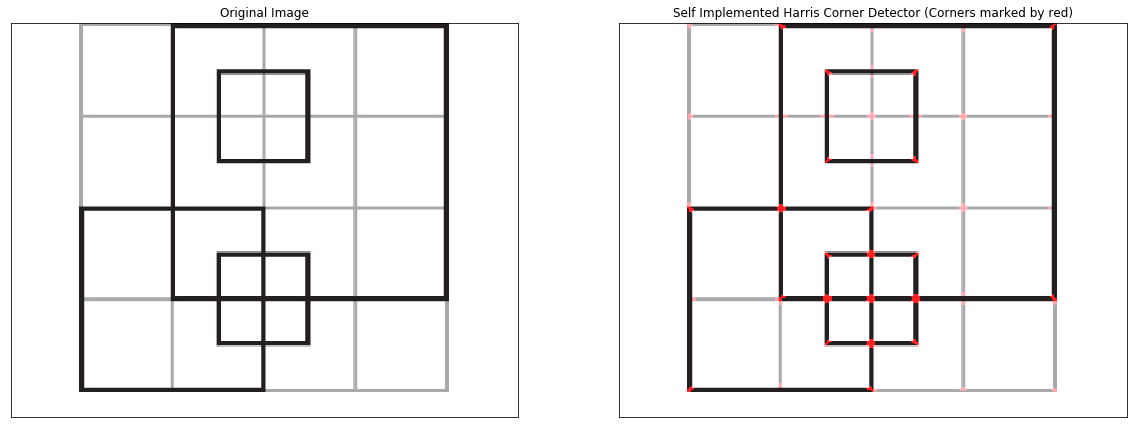

In [6]:
h = harrisCornerDetector(threshold=100)
img = mpimg.imread('box.jpg')
out = h.detect(img)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img,'gray')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.title('Self Implemented Harris Corner Detector (Corners marked by red)')
plt.imshow(out,'gray')
plt.xticks([])
plt.yticks([])
plt.show()

## Open-CV Harris Corner Detector

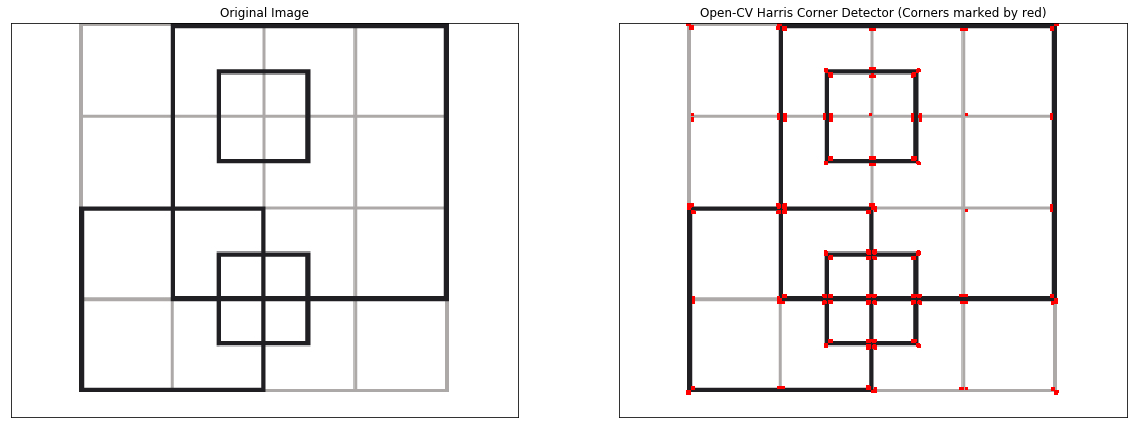

In [7]:
img = cv2.imread('box.jpg')
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img,'gray')
plt.xticks([])
plt.yticks([])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
img[dst>0.01*dst.max()]=[255,0,0]
plt.subplot(1,2,2)
plt.title('Open-CV Harris Corner Detector (Corners marked by red)')
plt.imshow(img,'gray')
plt.xticks([])
plt.yticks([])
plt.show()